# H1-2 Collision Avoidance Training Notebook

This notebook:
1. Runs MVP tests to validate the environment
2. Trains an asymmetric actor-critic policy with PPO
3. Evaluates and visualizes the trained policy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"

In [3]:
import functools
import json
from datetime import datetime

import jax
import jax.numpy as jp
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import wandb
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from etils import epath
from flax.training import orbax_utils
from IPython.display import clear_output, display
from orbax import checkpoint as ocp
from tqdm import tqdm

from mujoco_playground import locomotion, wrapper
from mujoco_playground.config import locomotion_params

# Enable persistent compilation cache
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

## Section 1: MVP Testing

Run basic tests to validate the environment before training.

In [ ]:
# Test configuration
env_name = "H12SkinAvoid"
env_cfg = locomotion.get_default_config(env_name)

# Override trajectory directory if needed
# env_cfg.traj_dir = "./traj_logs"

print("Environment configuration:")
print(f"  ctrl_dt: {env_cfg.ctrl_dt}")
print(f"  episode_length: {env_cfg.episode_length}")
print(f"  history_len: {env_cfg.history_len}")
print(f"  action_scale: {env_cfg.action_scale}")
print(f"  traj_dir: {env_cfg.traj_dir}")



Environment configuration:
  ctrl_dt: 0.01
  episode_length: 300
  history_len: 3
  action_scale: 0.6
  traj_dir: /home/humanoid/Programs/h1_mujoco/augmented


Loading environment...


W1205 14:23:09.929700   12113 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1205 14:23:09.932359   11759 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Downsampling trajectories by 5x: 500.0Hz -> 100.0Hz
Loading trajectory database from cache: /home/humanoid/Programs/h1_mujoco/augmented/traj_cache_ds5.pkl
Loaded 1623 trajectories from cache
Loaded trajectory database: {'num_trajectories': 1623, 'min_length': 22, 'max_length': 105, 'mean_length': 34.86937713623047, 'std_length': 12.518778800964355, 'total_timesteps': 56593}
Found 63 skin sensors
✓ Environment loaded successfully
  Controlled joints: 21
  Skin sensors: 63
  Action size: 21
  Trajectories loaded: 1623

Trajectory database stats:
  num_trajectories: 1623
  min_length: 22
  max_length: 105
  mean_length: 34.86937713623047
  std_length: 12.518778800964355
  total_timesteps: 56593


In [6]:
# Test reset
print("Testing reset...")
rng = jax.random.PRNGKey(0)
state = env.reset(rng)

print(f"✓ Reset successful")
print(f"  Observation keys: {state.obs.keys()}")
print(f"  Actor obs shape: {state.obs['state'].shape}")
print(f"  Critic obs shape: {state.obs['privileged_state'].shape}")
print(f"  Trajectory length: {state.info['traj_length']}")

# Check observation sizes
actor_size, critic_size = env._compute_obs_size()
print(f"\nComputed observation sizes:")
print(f"  Actor: {actor_size} (actual: {state.obs['state'].shape[0]})")
print(f"  Critic: {critic_size} (actual: {state.obs['privileged_state'].shape[0]})")

assert state.obs['state'].shape[0] == actor_size, "Actor obs size mismatch!"
assert state.obs['privileged_state'].shape[0] == critic_size, "Critic obs size mismatch!"
print("✓ Observation shapes validated")

Testing reset...


✓ Reset successful
  Observation keys: dict_keys(['state', 'privileged_state'])
  Actor obs shape: (534,)
  Critic obs shape: (540,)
  Trajectory length: 30

Computed observation sizes:
  Actor: 534 (actual: 534)
  Critic: 540 (actual: 540)
✓ Observation shapes validated


In [7]:
# Test step
print("Testing step...")
rng, action_rng = jax.random.split(rng)
action = jax.random.uniform(action_rng, shape=(env._num_controlled_joints,), minval=-1.0, maxval=1.0)
next_state = env.step(state, action)

print(f"✓ Step successful")
print(f"  Reward: {next_state.reward:.4f}")
print(f"  Done: {next_state.done}")
print(f"  Trajectory step: {next_state.info['traj_step']}/{next_state.info['traj_length']}")

# Print top reward components
print("\n  Top reward components:")
reward_items = [(k, float(v)) for k, v in next_state.metrics.items() if k.startswith('reward/')]
reward_items.sort(key=lambda x: abs(x[1]), reverse=True)
for k, v in reward_items[:10]:
    print(f"    {k}: {v:.6f}")

Testing step...
✓ Step successful
  Reward: -6.9440
  Done: 0.0
  Trajectory step: 1/30

  Top reward components:
    reward/torque: -692.793945
    reward/energy: -2.476268
    reward/action_rate: -0.916446
    reward/joint_pos_tracking: 0.914846
    reward/base_vel_tracking: 0.872906
    reward/joint_limit: 0.003136
    reward/base_angvel_tracking: 0.000000
    reward/clearance_reward: 0.000000
    reward/collision_penalty: -0.000000
    reward/joint_vel_tracking: 0.000000


In [8]:
# Test capacitance computation
print("Testing capacitance sensing...")
capacitances = state.info['capacitances']

print(f"  Num sensors: {len(capacitances)}")
print(f"  Num detections: {jp.sum(capacitances > 0.0):.0f}")
print(f"  Max capacitance: {jp.max(capacitances):.4f}")
min_nonzero = jp.min(jp.where(capacitances > 0, capacitances, jp.inf))
if jp.isfinite(min_nonzero):
    print(f"  Min (non-zero) capacitance: {min_nonzero:.4f}")
else:
    print(f"  No detections (obstacle far from robot)")

print(f"✓ Capacitance computation working")

Testing capacitance sensing...
  Num sensors: 63
  Num detections: 0
  Max capacitance: -1.0000
  No detections (obstacle far from robot)
✓ Capacitance computation working


In [9]:
# Test JIT compilation
print("Testing JIT compilation...")
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

rng = jax.random.PRNGKey(42)
state = jit_reset(rng)
action = jp.zeros(env._num_controlled_joints)
state = jit_step(state, action)

print("✓ JIT compilation successful")

Testing JIT compilation...
✓ JIT compilation successful


In [10]:
# Test short rollout
print("Testing 50-step rollout...")
rng = jax.random.PRNGKey(123)
state = jit_reset(rng)

total_reward = 0.0
collision_count = 0

for step in range(50):
    rng, action_rng = jax.random.split(rng)
    action = jax.random.uniform(action_rng, shape=(env._num_controlled_joints,), minval=-1.0, maxval=1.0)
    state = jit_step(state, action)
    total_reward += float(state.reward)
    
    if float(state.metrics['collision_detected']) > 0.5:
        collision_count += 1
    
    if float(state.done) > 0.5:
        print(f"  Episode terminated at step {step+1}")
        break

print(f"✓ Rollout completed")
print(f"  Steps: {step+1}")
print(f"  Total reward: {total_reward:.2f}")
print(f"  Avg reward: {total_reward/(step+1):.4f}")
print(f"  Collisions: {collision_count}")

Testing 50-step rollout...
  Episode terminated at step 13
✓ Rollout completed
  Steps: 13
  Total reward: -60.41
  Avg reward: -4.6468
  Collisions: 0


## Section 2: Training Setup

Configure PPO training parameters and initialize W&B logging.

In [ ]:
# Get PPO parameters
# You'll need to create this in locomotion_params.py
# For now, let's create basic parameters
from ml_collections import config_dict

ppo_params = config_dict.ConfigDict()
ppo_params.num_timesteps = 100_000_000  # 10M steps
ppo_params.num_evals = 20
ppo_params.reward_scaling = 1.0
ppo_params.episode_length = env_cfg.episode_length
ppo_params.normalize_observations = True
ppo_params.action_repeat = 1
ppo_params.unroll_length = 10
ppo_params.num_minibatches = 32
ppo_params.num_updates_per_batch = 4
ppo_params.discounting = 0.97
ppo_params.learning_rate = 3e-4
ppo_params.entropy_cost = 1e-3
ppo_params.num_envs = 2048
ppo_params.batch_size = 2048
ppo_params.seed = 0

# Network architecture for asymmetric actor-critic
ppo_params.network_factory = config_dict.ConfigDict()
ppo_params.network_factory.policy_hidden_layer_sizes = (512, 256, 128)
ppo_params.network_factory.value_hidden_layer_sizes = (512, 256, 128)

from pprint import pprint
print("PPO Parameters:")
pprint(ppo_params.to_dict())

PPO Parameters:
{'action_repeat': 1,
 'batch_size': 2048,
 'discounting': 0.97,
 'entropy_cost': 0.001,
 'episode_length': 300,
 'learning_rate': 0.0003,
 'network_factory': {'policy_hidden_layer_sizes': (512, 256, 128),
                     'value_hidden_layer_sizes': (512, 256, 128)},
 'normalize_observations': True,
 'num_envs': 2048,
 'num_evals': 20,
 'num_minibatches': 32,
 'num_timesteps': 10000000,
 'num_updates_per_batch': 4,
 'reward_scaling': 1.0,
 'seed': 0,
 'unroll_length': 10}


In [12]:
# Alternatively, if you've added to locomotion_params.py:
# ppo_params = locomotion_params.brax_ppo_config(env_name)

In [13]:
# Setup wandb logging
USE_WANDB = True  # Set to True to enable W&B logging

if USE_WANDB:
    wandb.init(project="mjxrl-avoid", config=env_cfg)
    wandb.config.update({"env_name": env_name})
    wandb.config.update(ppo_params.to_dict())

wandb: Currently logged in as: badinkajink (correlllab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [14]:
# Setup checkpointing
SUFFIX = None  # Add suffix to experiment name if desired
FINETUNE_PATH = None  # Set to checkpoint path to resume training

# Generate unique experiment name
now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
exp_name = f"{env_name}-{timestamp}"
if SUFFIX is not None:
    exp_name += f"-{SUFFIX}"
print(f"Experiment name: {exp_name}")

# Possibly restore from checkpoint
if FINETUNE_PATH is not None:
    FINETUNE_PATH = epath.Path(FINETUNE_PATH)
    latest_ckpts = list(FINETUNE_PATH.glob("*"))
    latest_ckpts = [ckpt for ckpt in latest_ckpts if ckpt.is_dir()]
    latest_ckpts.sort(key=lambda x: int(x.name))
    latest_ckpt = latest_ckpts[-1]
    restore_checkpoint_path = latest_ckpt
    print(f"Restoring from: {restore_checkpoint_path}")
else:
    restore_checkpoint_path = None

Experiment name: H12SkinAvoid-20251205-142444


In [15]:
# Create checkpoint directory
ckpt_path = epath.Path("checkpoints").resolve() / exp_name
ckpt_path.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint path: {ckpt_path}")

# Save config
with open(ckpt_path / "config.json", "w") as fp:
    json.dump(env_cfg.to_dict(), fp, indent=4)

Checkpoint path: /home/humanoid/Programs/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/H12SkinAvoid-20251205-142444


## Section 3: Training

Train the asymmetric actor-critic policy with PPO.

In [16]:
# Setup progress tracking
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
    """Progress callback for training."""
    # Log to wandb
    if USE_WANDB:
        wandb.log(metrics, step=num_steps)

    # Plot
    clear_output(wait=True)
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics["eval/episode_reward"])
    y_dataerr.append(metrics["eval/episode_reward_std"])

    plt.xlim([0, ppo_params.num_timesteps * 1.25])
    # plt.ylim([0, 100])  # Adjust based on your expected reward range
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.title(f"y={y_data[-1]:.3f}")
    plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

    display(plt.gcf())


def policy_params_fn(current_step, make_policy, params):
    """Checkpoint callback."""
    del make_policy  # Unused
    orbax_checkpointer = ocp.PyTreeCheckpointer()
    save_args = orbax_utils.save_args_from_target(params)
    path = ckpt_path / f"{current_step}"
    orbax_checkpointer.save(path, params, force=True, save_args=save_args)

In [17]:
# Setup training function
# Get domain randomization if available
try:
    randomizer = locomotion.get_domain_randomizer(env_name)
except:
    randomizer = None
    print("No domain randomizer found, using None")

training_params = dict(ppo_params)
del training_params["network_factory"]

train_fn = functools.partial(
    ppo.train,
    **training_params,
    network_factory=functools.partial(
        ppo_networks.make_ppo_networks,
        **ppo_params.network_factory
    ),
    restore_checkpoint_path=restore_checkpoint_path,
    progress_fn=progress,
    wrap_env_fn=wrapper.wrap_for_brax_training,
    policy_params_fn=policy_params_fn,
    randomization_fn=randomizer,
)

Env 'H12SkinAvoid' does not have a domain randomizer in the locomotion registry.


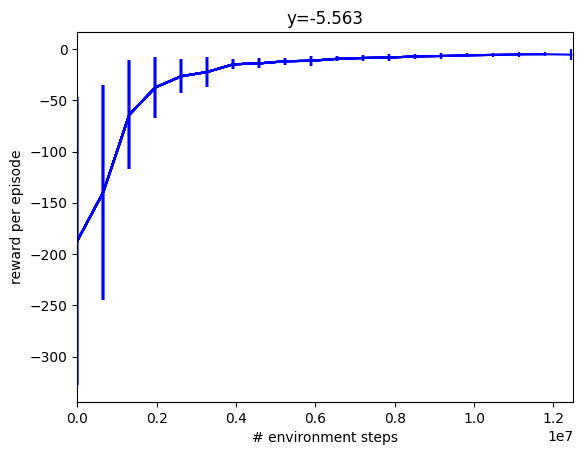


Time to jit: 0:01:16.202149
Time to train: 0:03:38.194457


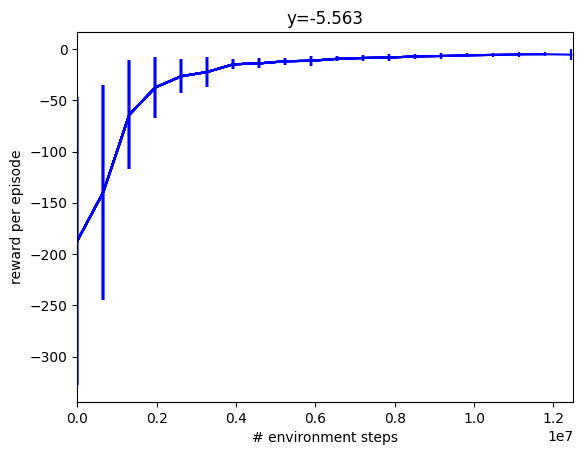

In [18]:
# Train!
print("Starting training...")
print(f"Total timesteps: {ppo_params.num_timesteps:,}")
print(f"Number of environments: {ppo_params.num_envs}")
print(f"Batch size: {ppo_params.batch_size}")

env = locomotion.load(env_name, config=env_cfg)
eval_env = locomotion.load(env_name, config=env_cfg)
make_inference_fn, params, _ = train_fn(environment=env, eval_env=eval_env)

if len(times) > 1:
    print(f"\nTime to jit: {times[1] - times[0]}")
    print(f"Time to train: {times[-1] - times[1]}")

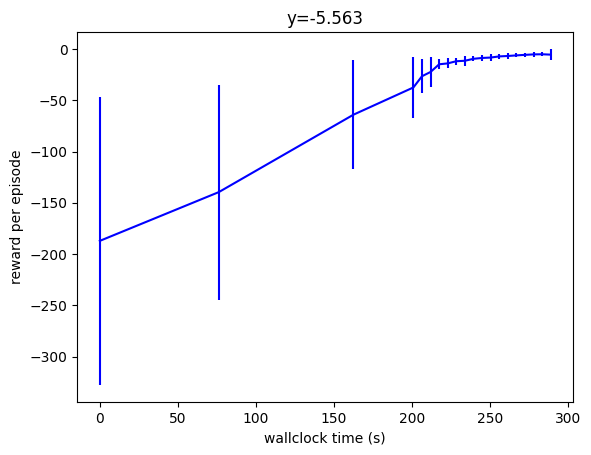

In [19]:
# Final plot of reward vs wallclock time
plt.figure()
# plt.ylim([0, 100])
plt.xlabel("wallclock time (s)")
plt.ylabel("reward per episode")
plt.title(f"y={y_data[-1]:.3f}")
plt.errorbar(
    [(t - times[0]).total_seconds() for t in times[:-1]],
    y_data,
    yerr=y_dataerr,
    color="blue",
)
plt.show()

In [20]:
# Save normalizer and policy params
import pickle

normalizer_params, policy_params, value_params = params
with open(ckpt_path / "params.pkl", "wb") as f:
    data = {
        "normalizer_params": normalizer_params,
        "policy_params": policy_params,
        "value_params": value_params,
    }
    pickle.dump(data, f)

print(f"Parameters saved to {ckpt_path / 'params.pkl'}")

Parameters saved to /home/humanoid/Programs/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/H12SkinAvoid-20251205-142444/params.pkl


## Section 4: Evaluation

Evaluate the trained policy and visualize rollouts.

In [21]:
# Setup inference
inference_fn = make_inference_fn(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

eval_env = locomotion.load(env_name, config=env_cfg)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

Downsampling trajectories by 5x: 500.0Hz -> 100.0Hz
Loading trajectory database from cache: /home/humanoid/Programs/h1_mujoco/augmented/traj_cache_ds5.pkl
Loaded 1623 trajectories from cache
Loaded trajectory database: {'num_trajectories': 1623, 'min_length': 22, 'max_length': 105, 'mean_length': 34.86937713623047, 'std_length': 12.518778800964355, 'total_timesteps': 56593}
Found 63 skin sensors


In [22]:
# Run evaluation rollouts
print("Running evaluation rollouts...")
rng = jax.random.PRNGKey(12345)
rollout = []
rewards = []
tracking_rewards = []
recovery_rewards = []
collision_rewards = []
capacitances_max = []
tracking_errors = []

num_episodes = 10
for ep in tqdm(range(num_episodes)):
    rng, reset_rng = jax.random.split(rng)
    state = jit_reset(reset_rng)
    
    for i in range(env_cfg.episode_length):
        act_rng, rng = jax.random.split(rng)
        ctrl, _ = jit_inference_fn(state.obs, act_rng)
        state = jit_step(state, ctrl)
        
        rollout.append(state)
        rewards.append(
            {k[7:]: float(v) for k, v in state.metrics.items() if k.startswith("reward/")}
        )
        tracking_rewards.append(float(state.metrics['reward/joint_pos_tracking']))
        recovery_rewards.append(float(state.metrics['reward/recovery_upright']))
        collision_rewards.append(float(state.metrics['reward/collision_penalty']))
        capacitances_max.append(float(jp.max(state.info['capacitances'])))
        tracking_errors.append(float(state.metrics['tracking_error']))
        
        if state.done:
            print(f"  Episode {ep} terminated at step {i}")
            break

print(f"\nCollected {len(rollout)} timesteps from {num_episodes} episodes")

Running evaluation rollouts...


100%|██████████| 10/10 [00:32<00:00,  3.20s/it]

  Episode 0 terminated at step 3
  Episode 1 terminated at step 3
  Episode 2 terminated at step 3
  Episode 3 terminated at step 4
  Episode 4 terminated at step 3
  Episode 5 terminated at step 3
  Episode 6 terminated at step 3
  Episode 7 terminated at step 4
  Episode 8 terminated at step 3
  Episode 9 terminated at step 3

Collected 42 timesteps from 10 episodes


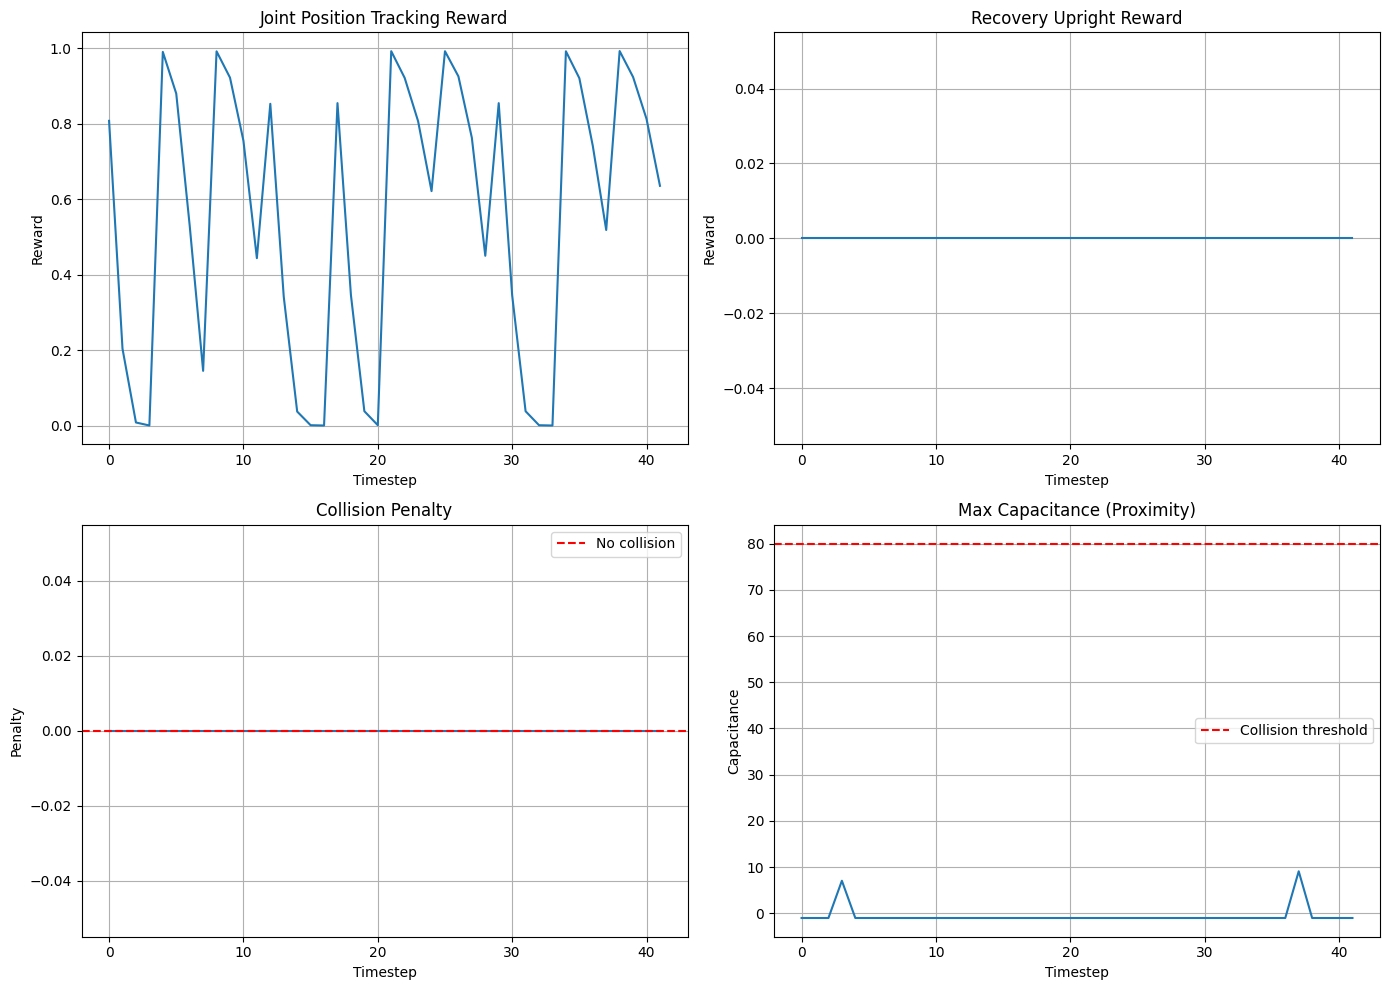

In [23]:
# Plot reward components over time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Tracking reward
axes[0, 0].plot(tracking_rewards)
axes[0, 0].set_title('Joint Position Tracking Reward')
axes[0, 0].set_xlabel('Timestep')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].grid(True)

# Recovery reward
axes[0, 1].plot(recovery_rewards)
axes[0, 1].set_title('Recovery Upright Reward')
axes[0, 1].set_xlabel('Timestep')
axes[0, 1].set_ylabel('Reward')
axes[0, 1].grid(True)

# Collision penalty
axes[1, 0].plot(collision_rewards)
axes[1, 0].set_title('Collision Penalty')
axes[1, 0].set_xlabel('Timestep')
axes[1, 0].set_ylabel('Penalty')
axes[1, 0].axhline(y=0, color='r', linestyle='--', label='No collision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Max capacitance
axes[1, 1].plot(capacitances_max)
axes[1, 1].set_title('Max Capacitance (Proximity)')
axes[1, 1].set_xlabel('Timestep')
axes[1, 1].set_ylabel('Capacitance')
axes[1, 1].axhline(y=env._cap_collision_threshold, color='r', linestyle='--', label='Collision threshold')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

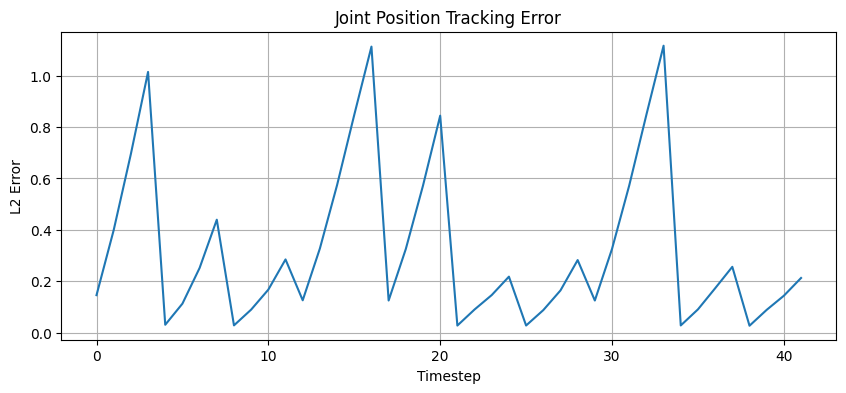

Mean tracking error: 0.3232
Std tracking error: 0.3105


In [24]:
# Plot tracking error over time
plt.figure(figsize=(10, 4))
plt.plot(tracking_errors)
plt.title('Joint Position Tracking Error')
plt.xlabel('Timestep')
plt.ylabel('L2 Error')
plt.grid(True)
plt.show()

print(f"Mean tracking error: {jp.mean(jp.array(tracking_errors)):.4f}")
print(f"Std tracking error: {jp.std(jp.array(tracking_errors)):.4f}")

In [25]:
# Analyze collision statistics
num_collisions = sum(1 for r in collision_rewards if r < 0)
collision_rate = num_collisions / len(collision_rewards)

print(f"Collision Statistics:")
print(f"  Total timesteps: {len(collision_rewards)}")
print(f"  Collisions detected: {num_collisions}")
print(f"  Collision rate: {collision_rate*100:.2f}%")
print(f"  Max capacitance observed: {max(capacitances_max):.4f}")

Collision Statistics:
  Total timesteps: 42
  Collisions detected: 0
  Collision rate: 0.00%
  Max capacitance observed: 9.1050


In [27]:
for i in range(eval_env.mj_model.ncam):
    print(f"Camera {i}: {eval_env.mj_model.camera(i).name}")

In [29]:
# Render video
print("Rendering video...")
render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = eval_env.render(
    traj, camera=None, scene_option=scene_option, height=480, width=640
)
media.show_video(frames, fps=fps, loop=False)

# Optionally save video
# media.write_video(f"{env_name}.mp4", frames, fps=fps, qp=18)

Rendering video...


100%|██████████| 21/21 [00:00<00:00, 373.00it/s]


## Section 5: Analysis

Additional analysis and visualization.

In [30]:
# Analyze reward distribution
if rewards:
    # Get all unique reward keys
    all_keys = set()
    for r in rewards:
        all_keys.update(r.keys())
    
    # Compute mean and std for each component
    print("Reward Component Statistics:")
    print(f"{'Component':<30} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
    print("-" * 78)
    
    for key in sorted(all_keys):
        values = [r.get(key, 0.0) for r in rewards]
        values = jp.array(values)
        print(f"{key:<30} {jp.mean(values):>12.4f} {jp.std(values):>12.4f} {jp.min(values):>12.4f} {jp.max(values):>12.4f}")

Reward Component Statistics:
Component                              Mean          Std          Min          Max
------------------------------------------------------------------------------
action_rate                         -0.0417       0.0583      -0.1591      -0.0023
base_angvel_tracking                 0.0468       0.1159       0.0000       0.4828
base_vel_tracking                    0.5985       0.3839       0.0198       0.9940
clearance_reward                     0.0000       0.0000       0.0000       0.0000
collision_penalty                    0.0000       0.0000      -0.0000      -0.0000
energy                              -0.3588       0.1350      -0.8854      -0.2094
joint_limit                          0.0116       0.0055       0.0040       0.0216
joint_pos_tracking                   0.5570       0.3753       0.0000       0.9925
joint_vel_tracking                   0.0000       0.0000       0.0000       0.0000
proximity_penalty                   -0.0692       0.3795      

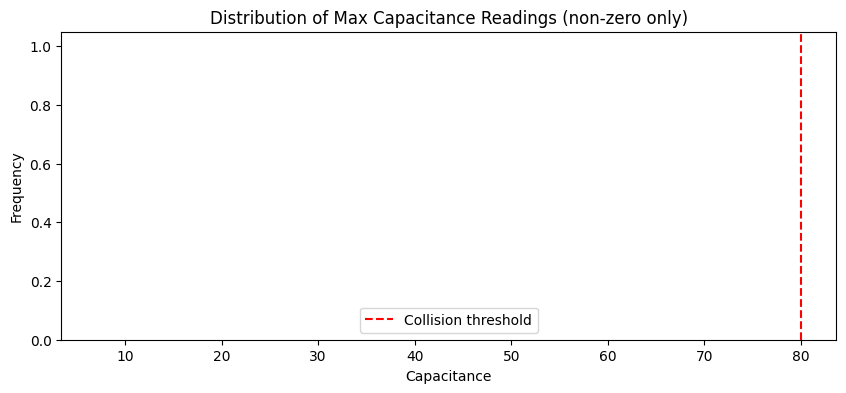

In [31]:
# Plot histogram of capacitance readings
plt.figure(figsize=(10, 4))
cap_nonzero = [c for c in capacitances_max if c > 0]
if cap_nonzero:
    plt.hist(cap_nonzero, bins=50)
    plt.axvline(x=env._cap_collision_threshold, color='r', linestyle='--', label='Collision threshold')
    plt.xlabel('Capacitance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Max Capacitance Readings (non-zero only)')
    plt.legend()
    plt.show()
else:
    print("No non-zero capacitance readings detected")

In [32]:
# Save analysis results
analysis_results = {
    'num_episodes': num_episodes,
    'total_timesteps': len(rollout),
    'collision_rate': float(collision_rate),
    'mean_tracking_error': float(jp.mean(jp.array(tracking_errors))),
    'std_tracking_error': float(jp.std(jp.array(tracking_errors))),
    'max_capacitance': float(max(capacitances_max)) if capacitances_max else 0.0,
}

with open(ckpt_path / "eval_results.json", "w") as f:
    json.dump(analysis_results, f, indent=4)

print(f"\nAnalysis results saved to {ckpt_path / 'eval_results.json'}")
print("\nEvaluation Summary:")
for key, value in analysis_results.items():
    print(f"  {key}: {value}")


Analysis results saved to /home/humanoid/Programs/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/H12SkinAvoid-20251205-142444/eval_results.json

Evaluation Summary:
  num_episodes: 10
  total_timesteps: 42
  collision_rate: 0.0
  mean_tracking_error: 0.3231772482395172
  std_tracking_error: 0.3105263113975525
  max_capacitance: 9.10495662689209


In [33]:
# Finish W&B run
if USE_WANDB:
    wandb.finish()
    print("W&B run finished")

eval/avg_episode_length,██▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/episode_collision_detected,██▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/episode_collision_detected_std,▇█▇▆▅▃▁▂▁▂▁▁▂▁▂▁▁▁▁▃
eval/episode_reward,▁▃▆▇▇▇██████████████
eval/episode_reward/action_rate,▁▂▅▇▇▇██████████████
eval/episode_reward/action_rate_std,█▇▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/episode_reward/base_angvel_tracking,██▃▃▃▆▅█▄▁▃▂▂▂▄▁▃▂▃▂
eval/episode_reward/base_angvel_tracking_std,█▆▁▃▁▆▄▆▃▁▂▂▁▃▄▁▂▂▂▁
eval/episode_reward/base_vel_tracking,██▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
eval/episode_reward/base_vel_tracking_std,██▅▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
+41,...


W&B run finished


# Debug

In [ ]:
# db = eval_env._traj_db
# for i in range(5):
#     traj_qpos = db.stacked_trajectories['robot_qpos'][i]  # (max_len, 19)
#     traj_len = db.trajectory_lengths[i]  # Actual length (not padded)
    
#     # Only compute std over actual trajectory (not padding)
#     qpos_actual = traj_qpos[:traj_len]
#     qpos_std = jp.std(qpos_actual, axis=0)
#     print(f"Traj {i} (len={traj_len}): mean std = {jp.mean(qpos_std):.4f}")

'''
# Evaluation with diagnostics
rng = jax.random.PRNGKey(203)
state = jit_reset(rng)

print(f"Trajectory length: {state.info['traj_length']}")
print(f"Initial robot qpos: {state.data.qpos[env._controlled_joint_indices][:5]}...")
print(f"Initial ref qpos: {state.info['current_trajectory']['robot_qpos'][0][:5]}...")

for i in range(min(100, env_cfg.episode_length)):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    
    if i % 1 == 0:
        # Check what's happening
        ref = eval_env._traj_db.get_reference_at_step(
            state.info['current_trajectory'], 
            state.info['traj_step']
        )
        current_qpos = state.data.qpos[env._controlled_joint_indices]
        
        print(f"\nStep {i} (traj_step {state.info['traj_step']}/{state.info['traj_length']}):")
        print(f"  Action magnitude: {float(jp.linalg.norm(ctrl)):.4f}")
        print(f"  Action range: [{float(jp.min(ctrl)):.3f}, {float(jp.max(ctrl)):.3f}]")
        print(f"  Tracking error: {float(jp.linalg.norm(current_qpos - ref['robot_qpos'])):.4f}")
        print(f"  Reward total: {float(state.reward):.4f}")
        print(f"  Reward tracking: {float(state.metrics['reward/joint_pos_tracking']):.6f}")
        print(f"  Penalty action_rate: {float(state.metrics['reward/action_rate']):.6f}")
        print(f"  Penalty torque: {float(state.metrics['reward/torque']):.6f}")
    
    if state.done:
        print(f"Episode terminated at step {i}")
        break
'''

'''
for i in range(min(100, env_cfg.episode_length)):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    
    if i < 5:  # Check first few steps
        joint_angles = state.data.qpos[env._controlled_joint_indices]
        gravity = eval_env.get_gravity(state.data)
        capacitances = state.info['capacitances']
        base_pos = state.data.qpos[0:3]
        
        print(f"\nStep {i}:")
        print(f"  Joint limit check: any < lower? {jp.any(joint_angles < env._lowers)}")
        print(f"  Joint limit check: any > upper? {jp.any(joint_angles > env._uppers)}")
        print(f"  Fall check: gravity[2] = {float(gravity[2]):.3f} (< 0.85?)")
        print(f"  Collision check: max cap = {float(jp.max(capacitances)):.3f} (> {env._cap_collision_threshold}?)")
        print(f"  Distance check: {float(jp.linalg.norm(base_pos[:2])):.3f} (> 5.0?)")
        print(f"  Done: {state.done}")
    
    if state.done:
        print(f"Episode terminated at step {i}")
        break
'''

'''
state = jit_reset(rng)
joint_angles = state.data.qpos[env._controlled_joint_indices]

print("Joint limit violations at reset:")
for i, (angle, lower, upper) in enumerate(zip(joint_angles, env._lowers, env._uppers)):
    if angle < lower or angle > upper:
        print(f"  Joint {i}: {float(angle):.4f} not in [{float(lower):.4f}, {float(upper):.4f}]")
        violation = "BELOW" if angle < lower else "ABOVE"
        print(f"    -> {violation} limit by {float(abs(angle - (lower if angle < lower else upper))):.4f}")

# Check trajectory initial states
db = eval_env._traj_db
for i in range(3):
    traj_qpos = db.stacked_trajectories['robot_qpos'][i][0]  # First timestep
    violations = (traj_qpos < env._lowers) | (traj_qpos > env._uppers)
    if jp.any(violations):
        print(f"Traj {i} has {jp.sum(violations)} joint limit violations at start")
        for j in jp.where(violations)[0]:
            print(f"  Joint {j}: {float(traj_qpos[j]):.4f} not in [{float(env._lowers[j]):.4f}, {float(env._uppers[j]):.4f}]")

print(f"Number of actuators: {env.mj_model.nu}")
print(f"Number of controlled joints: {env._num_controlled_joints}")
print(f"Controlled indices: {env._controlled_joint_indices}")
print(f"Limits shape: {env._lowers.shape}")
'''